$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\norm}[1]{\|#1\|_2}
$$

In [1]:
from __future__ import division

# plotting
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
from mpl_toolkits.mplot3d import Axes3D
if "bmh" in plt.style.available: plt.style.use("bmh");

# scientific
import numpy as np;
import scipy as scp;
import scipy.stats;

# scikit-learn
import sklearn;
from sklearn.kernel_ridge import KernelRidge;

# python
import random;

# warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# rise config
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'simple',
              'start_slideshow_at': 'selected',
              'transition':'fade',
              'scroll': False
})

{'margin': 0.1,
 'minScale': 0.5,
 'scroll': False,
 'start_slideshow_at': 'selected',
 'theme': 'simple',
 'transition': 'fade'}

# EECS 545:  Machine Learning
## Lecture 09:  Kernel Methods & Support Vector Machines
* Instructor:  **Jacob Abernethy**
* Date:  February 10, 2015

*Lecture Exposition Credit: Ben, Saket, & Valli*

## References

This lecture draws upon the following resources:

- **[PRML]** Bishop, Christopher.  [*Pattern Recognition and Machine Learning*](http://www.springer.com/us/book/9780387310732).  2006.
- **[CS229]** Ng, Andrew.  [CS 229:  Machine Learning](http://cs229.stanford.edu/).  Autumn 2015.
    - Lecture Notes 03:  [Support Vector Machines & Kernels](http://cs229.stanford.edu/notes/cs229-notes3.pdf)
- Eric Kim 2013, [Everything You Wanted to Know about the Kernel Trick](http://www.eric-kim.net/eric-kim-net/posts/1/kernel_trick.html)

## Outline

- Dual Representations
    - *Review*:  Kernel Trick
    - *Example*:  Linear Regression
- Kernel Regression
- Support Vector Machines

# Dual Representations: Linear Regression

> Following **[PRML]** Chapter 6.1

### Review:  Kernel Trick

By using different definitions for inner product, we can 
- compute inner products in a high dimensional space
- with computational complexity of a low dimensional space

Many algorithms can be expressed completely in terms of kernels $\kappa(x,x’)$, rather than other operations on $x$.
- In this case, you can replace one kernel with another, and get a new algorithm that works over a different domain.

### Dual Representations:  Kernel Trick

* The dual representation, and its solutions, are entirely written in terms of kernels.

* The elements of the Gram matrix  $ K =\Phi \Phi^T $
$$ K_{ij} = \kappa(x_i, x_j) = \phi(x_i)^T \phi(x_j) $$

* These represent the pairwise similarities among all the observed feature vectors.
    - We may be able to compute the kernels more efficiently than the feature vectors.

### Dual Representations:  Linear Regression

Recall the **error function** for regularized linear regression,
$$
\begin{align}
J(w)
&= \frac{1}{2} \sum_{n=1}^{N}(w^T \phi (x_n) - t_n)^2 +
    \frac{\lambda}{2}w^Tw \\
&= \frac12 w^T \Phi^T \Phi w - w^T \Phi^T t + \frac12 t^T t + 
    \frac{\lambda}{2} w^T w
\end{align}
$$


**Solution:** $ w_{ML} = (\Phi^T \Phi + \lambda I)^{-1}\Phi^T t $
* Recall the N x M design matrix that is central to this solution.
* We can approach the solution a different way 

### Review: The Design Matrix

The **design matrix** is a matrix $\Phi \in \mathbb{R}^{N \times M}$, applying
- the $M$ basis functions ($M$: number of columns) 
- to $N$ data points ($N$: number of rows)

Each *row* is a feature vector.  Our goal is $\boxed{ \Phi w \approx t}$.


$$
\Phi = \left\{
\begin{array}{cccc} 
\phi_0(x_1) & \phi_1(x_1) & \cdots & \phi_{M-1}(x_1)  \\ 
\phi_0(x_2) & \phi_1(x_2) & \cdots & \phi_{M-1}(x_2)  \\
\vdots & \vdots & \ddots & \vdots  \\
\phi_0(x_N) & \phi_1(x_N) & \dots & \phi_{M-1}(x_N)  \\
\end{array}
\right\}
$$

### Review:  The Gram Matrix

For regression, a key item is the *"covariance"* matrix,
$$ \Phi^T \Phi  \in \R^{M \times M}$$
(Actual cov. matrix requires mean centering normalizing)

Here, we will use the **Gram matrix** (*pairwise similarity*)
$$ K = \Phi \Phi^T \in \R^{N \times N}$$ 


Note $ K_{ij} = \phi(x_i)^T \phi(x_j) $
encapsulates the pairwise similarities of all training points
- Kernel methods use only $ K$ , not $\Phi$.

### Dual Representations:  Linear Regression
We want to min: $J(w)
= \frac{1}{2} \sum_{n=1}^{N}(w^T \phi (x_n) - t_n)^2 + \frac{\lambda}{2}w^Tw$

Taking $\nabla J(w) = 0$, we obtain:
$$
\begin{align}
w 
&= -\frac{1}{\lambda}\sum_{n=1}^{N}(w^T\phi(x_n) - t_n) \phi(x_n) \\
&= \sum_{n=1}^{N}a_n\phi(x_n) = \Phi^Ta
\end{align}
$$
Notice: $w$ can be written as a linear combination of the $\phi(x_n)$!

Transform $J(w)$ to $J(a)$ by substituting $ w = \Phi^T a$
- Where $a_n = -\frac{1}{\lambda}\left\{w^T\phi(x_n) - t_n)\right\}$
- Let $a = (a_1, \dots, a_N)^T$ be the parameter, instead of $w$.

### Dual Representations:  Linear Regression

**Dual:**  Substituting $w = \Phi^Ta$,
$$
\begin{align}
J(a) 
&= \frac12 w^T \Phi^T \Phi w - w^T \Phi^T t + \frac12 t^T t + \frac{\lambda}{2} w^T w \\
&= \frac{1}{2} (a^T\Phi) \Phi^T \Phi (\Phi^Ta) - (a^T\Phi) \Phi^Tt + \frac{1}{2}t^Tt + \frac{\lambda}{2}(a^T\Phi)(\Phi^Ta) \\
&= \frac{1}{2}a^TKKa - a^T Kt + \frac{1}{2}t^Tt + \frac{\lambda}{2}a^TKa
\end{align}
$$

<div style="color: red; margin:20px auto; max-width: 500px;">**Note to Jake:**  The following slide is an exact copy of the one above, except for changes in parentheses to emphasize the creation of Gram matrices out of the $\Phi^T\Phi$.  <br><br>Duplicating cells reduces readability of the notebook but I think it's nice to see in this case.  I suppose this is one disadvantage of notebooks vs. traditional slides.</div>

### Dual Representations:  Linear Regression

**Dual:**  Substituting $w = \Phi^Ta$,
$$
\begin{align}
J(a) 
&= \frac12 w^T \Phi^T \Phi w - w^T \Phi^T t + \frac12 t^T t + \frac{\lambda}{2} w^T w \\
&= \frac{1}{2} a^T (\Phi \Phi^T) (\Phi \Phi^T) a - a^T (\Phi\Phi^T) t + \frac{1}{2}t^Tt + \frac{\lambda}{2}a^T(\Phi\Phi^T)a \\
&= \frac{1}{2}a^TKKa - a^TKt + \frac{1}{2}t^Tt + \frac{\lambda}{2}a^TKa
\end{align}
$$

### Dual Representations:  Linear Regression

**Dual:**  Substituting $w = \Phi^Ta$,
$$
J(a) 
= \frac{1}{2}a^TKKa - a^T Kt + \frac{1}{2}t^Tt + \frac{\lambda}{2}a^TKa
$$
**Prediction**:  Hypothesis becomes
$$
y(x)
= w^T\phi(x)
= a^T \Phi\phi(x) = a^T \mathbf{k}(x)
$$
where
$$
\mathbf{k}(x) = \Phi \phi(x) = [k(x_1,x), \ldots, k(x_n,x)]^T
$$
We still need to solve for $a$!

### Dual Representations:  Summary

1. Transform $J(w)$ to $J(a)$ by using $w = \Phi^Ta$ and the Gram matrix $K = \Phi\Phi^T$
2. Find $a$ to minimize $J(a)$
    $$ \boxed{a = (K+\lambda I_N)^{-1}t} $$
3. For predictions (for query point/test example x)
    $$ 
    y(x)
    = w^T\phi(x)
    = a^T \Phi\phi(x) 
    = \mathbf{k}(x)^T (K+\lambda I_N)^{-1}t
    $$
    - where $\mathbf{k}(x)$ has elements $\kappa(x_1, x), \ldots, \kappa(x_n,x)$  

### Dual Representations:  Primal vs. Dual

**Primal**: $w = (\Phi^T\Phi + \lambda I_M)^{-1} \Phi^Tt $
- invert $\Phi^T \Phi \in \R^{M \times M}$
- cheaper since usually $N >> M$
- must explicitly construct features

**Dual**: $ a = (K + \lambda I_N)^{-1}t $
- invert Gram matrix $K \in \R^{N \times N}$
- use kernel trick to avoid feature construction
- use kernels $\kappa(x, x')$ to represent similarity over vectors, images, sequences, graphs, text, etc..
    


# Kernel Regression

> For more details, see **[PRML]** Chapter 6.3

### Kernel Regression

Recall the **Gaussian Kernel**:
$$
\kappa(x, z)
= \exp \left\{-\frac{||x- z||^2}{2\sigma^2} \right\}
= \exp \left\{- \gamma ||x- z||^2 \right\} 
$$

From training data $\{ (x_1,t_1), \dots, (x_N,t_N)\}$, **Kernel Regression** outputs:
$$
y(x) = \frac{1}{\sum_{n=1}^N \kappa(x,x_n)} \sum_{n=1}^N \kappa(x, x_n) t_n
$$

- approximates $y(x)$ with a weighted sum of nearby points
- any distance metric or kernel can be used

### Kernel Regression:  Example Code

In [12]:
def plot_kernel_ridge(X, y, gamma=0.5, alpha=0.1):
    # kernel (ridge) regression
    krr = KernelRidge(kernel="rbf", gamma=gamma, alpha=alpha);
    krr.fit(X,y);

    # predict
    x_plot = np.linspace(min(X), max(X), 100)[:,np.newaxis];
    y_plot = krr.predict(x_plot);

    # plot
    plt.figure(figsize=(10,6));
    plt.plot(X, y, 'or');
    plt.plot(x_plot, y_plot)
    plt.title(r"Gaussian Kernel ($\gamma=%0.2f, \alpha=%0.2f$)" % (alpha,gamma), fontsize=16)

### Kernel Regression:  Linear + Noise

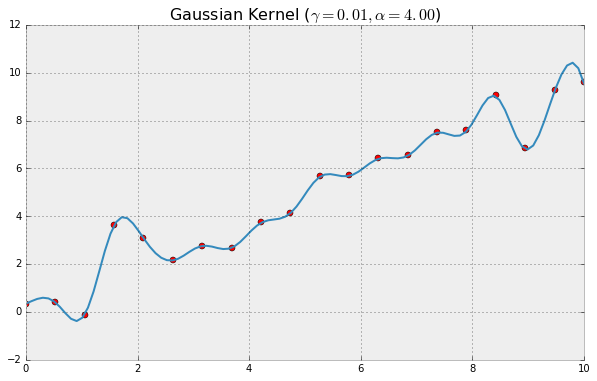

In [29]:
n = 20;
# linear + noise
X = np.linspace(0,10,n)[:,np.newaxis];
y = (X + np.random.randn(n,1)).ravel();
# plot
plot_kernel_ridge(X, y,gamma=4,alpha=0.01);

### Kernel Regression:  Sine + Linear + Noise

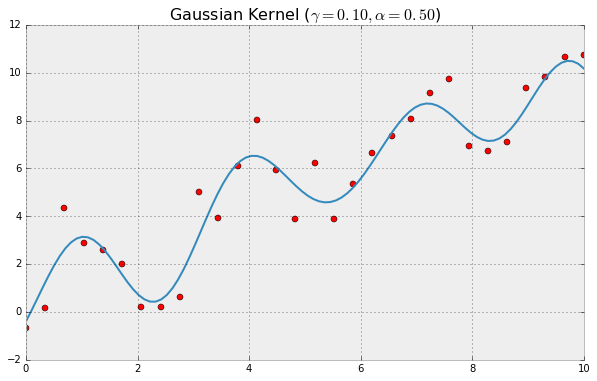

In [5]:
n = 30;
# sine + linear + noise
X = np.linspace(0,10,n)[:,np.newaxis];
y = (2*np.sin(X*2) + X + np.random.randn(n,1)).ravel();
# plot
plot_kernel_ridge(X, y);

### Kernel Regression:  Completely Random

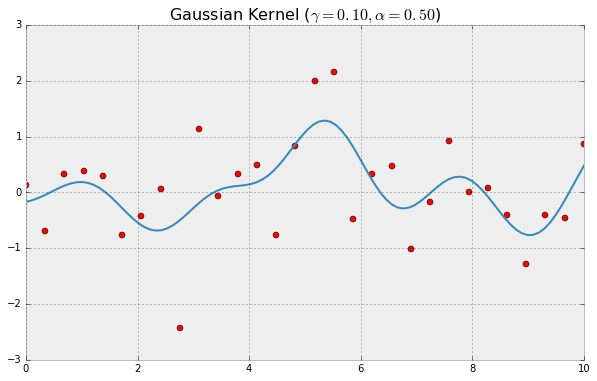

In [6]:
n = 30;
# completely random
X = np.linspace(0,10,n)[:,np.newaxis];
y = (np.random.randn(n)).ravel();
# plot
plot_kernel_ridge(X, y);

### Kernel Regression:  Classification

It is very easy to adapt kernel regression to **classification**!
- Data $\mathcal{D} = \{ (x_1,t_1), \dots, (x_N,t_N)\}$, Kernel $\kappa(x, x')$

**Regression**: if $t \in \R$ , return weighted average:
$$
y(x) = \frac{1}{\sum_{n=1}^N \kappa(x,x_n)} \sum_{n=1}^N \kappa(x, x_n) t_n
$$


**Classification** if $t \in \pm 1$ , return weighted majority:
$$ 
h(x) = \mathrm{sign}\left( \sum_{n=1}^N \kappa(x,x_n) t_n \right)
$$


### Comparison to Locally-Weighted Linear Regression

**Locally-weighted Linear Regression**
<div style="border: 1px solid black; display: block; padding: 15px; margin: 10px 0">
1. Fit $w$ to minimize $\sum_{n=1}^N r_n (t_n - w^T \phi(x_n) )^2$ for weights $r_n$
<br>
2. Output $w^T \phi(x)$
</div>
    
    
Use Gaussian Kernel, $r_n = \exp \left\{-\frac{||x- x_n||^2}{2\sigma^2} \right\}$

### Comparison to Locally-Weighted Linear Regression

**Similarities:**  Both methods are “instance-based learning”.
- Only observations (training set) close to the query point are considered (highly weighted) for regression computation.
- Kernel determines how to assign weights to training examples (similarity to the query point x)
- Free to choose types of kernels
- Both can suffer when the input dimension is high.
    

### Comparison to Locally-Weighted Linear Regression

**Differences:**
- *LWLR:*  Weighted regression; slow, but more accurate
- *KR:*  Weighted mean; faster, but less accurate

### Break Time!

<img src="https://media.giphy.com/media/mo8MAe2maHrva/giphy.gif">

# Support Vector Machines

### Review:  Linear Classifiers

Linear classifiers make decisions based on a linear (or more generally affine) combination of features.
- *Generative*: Fisher's LDA, GDA, Naive Bayes
- *Discriminative*: Logistic Regression, Perceptron

> What is the "best" linear classifier?

### Vapnik's Principle:

> "When solving a problem of interest, do not solve a more general problem as an intermediate step."

> "Don't solve a harder problem than you have to" 

### Discriminative vs. Generative?
- Generative models require estimation of (conditional) densities or mass functions.
- Often much easier to just determine the "decision boundary."

### Hyperplanes

An affine subspace one dimension fewer than its ambient space.
- The hyperplanes of a 2-D space are 1-D lines.
- The hyperplanes of a 3-D space are 2-D planes.

Mathematically, a **hyperplane** is of the form $$
\mathbb{H} = \{\mathbf{x} : \mathbf{w}^T\mathbf{x} + b = 0\}$$ 

where $\mathbf{w} \in \mathbb{R}^d$, $b \in \mathbb{R}$ and $d$ is the number of features.

### Point-Plane Distance

Given a hyperplane $\mathbb{H} = \{\mathbf{x} : \mathbf{w}^T\mathbf{x} + b = 0\}$ and a point $\mathbf{z} \not \in \mathbb{H}$, we can write $z$ as:
$$
z = z_0 + r \cdot \frac{\mathbf{w}}{||\mathbf{w}||}
$$
- for a unique $z_0 \in \mathbb{H}$ and $r\neq0$

- The distance is then given by $|r|$

### Calculating $|r|$

$$\begin{align}\mathbf{w}^T\mathbf{z} + b &=
\mathbf{w}^T\mathbf{z}_0 +b+ \mathbf{w}^T \left(r \cdot \frac{\mathbf{w}}{||\mathbf{w}||}\right) \\
&= r \frac{\mathbf{w}^T\mathbf{w}}{||\mathbf{w}||}
= r ||\mathbf{w}|| \end{align}
$$

Therefore, we have $\boxed{|r| = \frac{|\mathbf{w}^T \mathbf{z} + b|}{||\mathbf{w}||}}$

### Separating Hyperplanes

Provide a way of solving 2-class classification problems.

**Idea:** divide the vector space $\mathbb{R}^d$ where $d$ is the number of features into 2 "decision regions" with a $\mathbb{R}^{d - 1}$  subspace (a hyperplane).

### Maximum Margin Classifier

**(Functional) Margin:** The distance from a separating hyperplane to the closest datapoint of any class.

**Max. Margin Classifiers:** separate data by looking for the hyperplane that maximizes the margin.
- "best" linear classifier in terms of generalization
- misclassification unlikely with a wide margin between classes.

### Maximum Margin Classifier:  Example Code

In [7]:
# ADAPTED FROM SCIKIT-LEARN EXAMPLE
# (http://scikit-learn.org/stable/modules/svm.html)

def max_margin_classifier(ax, X, Y):
    clf = sklearn.svm.SVC(kernel='linear')
    clf.fit(X, Y)

    # get the separating hyperplane
    w = clf.coef_[0]
    m = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = m * xx - (clf.intercept_[0]) / w[1]

    # plot the parallel lines to the separating hyperplane that pass through the
    # support vectors
    t = clf.support_vectors_[0]
    yy_down = m * xx + (t[1] - m * t[0])
    t = clf.support_vectors_[-1]
    yy_up = m * xx + (t[1] - m * t[0])

    ax.plot(xx, yy, 'k-')
    ax.plot(xx, yy_down, 'k--')
    ax.plot(xx, yy_up, 'k--')

    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=120, facecolors='none', edgecolors='k', linewidth=3);
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, s=40)

    ax.axis('tight')
    
    return w

def plot_svc():
    # Create 30 random points
    np.random.seed()
    X = np.r_[np.random.randn(30, 2) - [3, 3], np.random.randn(30, 2) + [3, 3]]
    Y = [0] * 30 + [1] * 30

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    w = max_margin_classifier(ax, X, Y)
    plt.quiver(0, 0, 2 * w[0], 2 * w[0]/w[1],
               angles='xy', scale_units='xy', scale=2)
    
    plt.title("Support Vector Classifier");

### Maximum Margin Classifier:  Example

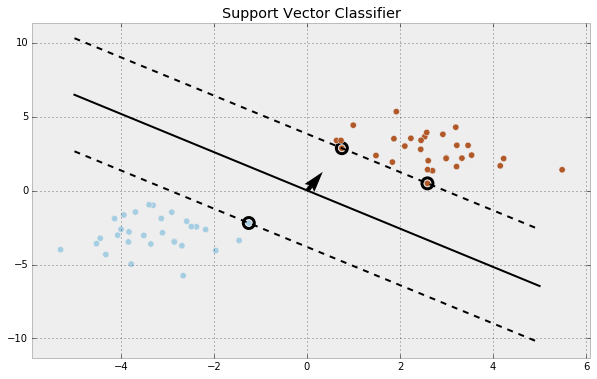

In [8]:
# Note: The separating hyperplane is the line between the two dotted lines. 
# The two dotted lines specify the margin and points on the margin are circled.
plot_svc();

### Margin Equation

The margin $\rho$ of a hyperplane is given by
$$
\rho
= \rho(w, b) 
= \min_{i = 1, ..., n} \frac{|\mathbf{w}^T\mathbf{x}_i + b|}{||\mathbf{w}||}
$$
- where $\mathbf{x}_i$ is the $i^\text{th}$ datapoint from the training set.

### Finding the Max-Margin Hyperplane

As with other linear classifiers, let the classifier be given by
$$
f(\mathbf{x})
= \text{sign}(\mathbf{w}^T\mathbf{x} + b)
$$

The maximum margin separating hyperplane is then given by the following optimization problem

$$
\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b}{\text{maximize}}
& & \rho(\mathbf{w}, b)\\
& \text{subject to}
& & y_i(\mathbf{w}^Tx_i + b) > 0
\end{aligned}
\end{equation*}
$$

### Canonical Form

- Let $m := \min_{i = 1, ..., n} |\mathbf{w_1}^T\mathbf{x}_i + b_1|$ (Simply renaming $\mathbf{w}$ as $\mathbf{w}_1$ and $b$ as $b_1$.
- Then, scaling $\mathbf{w}_1$ and $b_1$ by $\frac{1}{m}$ keeps the hyperplane unaffected.
- $\mathbf{w_2} = \frac{\mathbf{w_1}}{m}$ and $b_2 = \frac{b_1}{m}$ express the hyperplane in canonical form.

### Restatement of Optimization Problem

Using the canonical form, we can rewrite the optimization problem as $$\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b}{\text{maximize}\min_i} 
& & \frac{|\mathbf{w}^T\mathbf{x}_i + b|}{||\mathbf{w}||}\\
& \text{subject to}
& & y_i(\mathbf{w}^Tx_i + b) \geq 1, \forall i\\
& & & y_i(\mathbf{w}^Tx_i + b) = 1 \text{ for some } i
\end{aligned}
\end{equation*}$$

Simplifying further (**Exercise:** try to verify this!), we have $$\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b}{\text{minimize}} 
& & \frac{1}{2}{||\mathbf{w}||}^2\\
& \text{subject to}
& & y_i(\mathbf{w}^Tx_i + b) \geq 1, \forall i\\
\end{aligned}
\end{equation*}$$

### Linear Separability

- Two classes of data are said to be **linearly separable** if there exists a hyperplane that separates them without any errors.
- So far, we have looked at primarily linearly separable data where a single hyperplane will do for classification.
- We can extend on this notion to a multiclass scenario by considering data to be linearly separable if there exists a set of hyperplanes that can classify each class of examples from the rest (again without errors).

### Ideas for dealing with data that aren't linearly separable

- Use "slack" variables that allow for misclassification and penalize misclassification.
- Extend linear classifiers with kernels.

### Optimal Soft-Margin Hyperplane (OSMH)

Learn a linear classifier which solves 

$$
\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b, \mathbf{\xi}}{\text{minimize}} 
& & \frac{1}{2} {||\mathbf{w}||}^2 + \frac{C}{n} \sum_{i = 1}^n \xi_i\\
& \text{subject to}
& & y_i(\mathbf{w}^Tx_i + b) \geq 1 - \xi_i, i = 1, ..., n\\
& & & \xi_i \geq 0, i = 1, ..., n
\end{aligned}
\end{equation*}
$$

where we now have a new term that penalizes errors and accounts for the influence of outliers through a constant $C \geq 0$ (0 would lead us back to the hard margin case) and $\mathbf{\xi} = [\xi_1, ..., \xi_n]$ are the slack variables.

### OSMH:  Motivation

$$
\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b, \mathbf{\xi}}{\text{maximize}} 
& & \frac{1}{2} {||\mathbf{w}||}^2 + \frac{C}{n} \sum_{i = 1}^n \xi_i\\
& \text{subject to}
& & y_i(\mathbf{w}^Tx_i + b) \geq 1 - \xi_i, i = 1, ..., n\\
& & & \xi_i \geq 0, i = 1, ..., n
\end{aligned}
\end{equation*}
$$

* The **objective function** ensures margin is large *and* the margin violations are small
* The **first set of constraints** ensures classifier is doing well
    * similar to the prev. max-margin constraint, except we now allow for slack
* The second set of constraints ensure slack vars non-neg.
    * keeps the optimization problem from *"diverging"*

<div style="color: red; margin:20px auto; max-width: 500px;">**Note to Jake:**  This is about 45 slides in, and likely a good place to stop.  </div>

### The OSMH optimization problem

The OSMH optimization is a convex optimization problem
- objective function is quadratic
- inequality constraints are affine (and hence convex).

Note that strong duality holds.

### Review:  Lagrangian 

Consider a ** constrained optimization problem ** 

$$\begin{equation*}
\begin{aligned}
& \underset{\mathbf{x} \in \mathbb{R}^d}{\text{minimize}} 
& & f(\mathbf{x})\\
& \text{subject to}
& & g_i(\mathbf{x}) \leq 0, i = 1, ..., m\\
& & & h_j(x) = 0, j = 1, ..., n
\end{aligned}
\end{equation*}$$

The Lagrangian is then given by $$L(\mathbf{x}, \alpha, \beta) = f(\mathbf{x}) + \sum \limits_{i = 1}^m \alpha_i g_i(\mathbf{x}) + \sum \limits_{j = 1}^n \beta_j h_j(\mathbf{x})$$ 

Here, $\alpha$ and $\beta$ are the ** Lagrange Multipliers / Dual Variables ** associated with the inequality constraints and equality constraints repsectively.

### Review:  Lagrangian Dual 

- The Lagrangian Dual problem is given by $L_D (\alpha, \beta) = \min_{\mathbf{x}} L(\mathbf{x}, \alpha, \beta)$

- And, the Dual Optimization problem is given by $\max \limits_{\alpha, \beta: \alpha_i \geq 0} L_D(\alpha, \beta)$

- Note, $L_D$ is concave, because it is a piece-wise minimimum of affine functions.

- The Lagrange Primal Optiminization problem is given by $\min_{\mathbf{x}} \max \limits_{\alpha, \beta: \alpha_i \geq 0} L(\mathbf{x}, \alpha, \beta)$. $L_p(\mathbf{x}) = \begin{cases} f(x) & \text{ if } x \text{ is feasible}\\ \infty & \text{ otherwise}\end{cases}$

- Thus, primal and original problems have the same solution!

### Review:  Strong and Weak Duality 

$$p^* = \min \limits_{\mathbf{x}} L_p(\mathbf{x}) = \min_{\mathbf{x}} \max \limits_{\alpha, \beta: \alpha_i \geq 0} L(\mathbf{x}, \alpha, \beta)$$

$$d^* = \max \limits_{\alpha, \beta: \alpha_i \geq 0} L_D(\alpha, \beta) = \max \limits_{\alpha, \beta: \alpha_i \geq 0}\min_{\mathbf{x}} L(\mathbf{x}, \alpha, \beta)$$

- Weak duality: $d^* \leq p^*$
- Strong duality: $p^* = d^*$

- The original problem is said to be ** convex (cvx) ** is $f, g_1, ..., g_m$ are convex and $h_1, ..., h_n$ are affine. 

- If the original problem is cvx. and a constraint qualification holds, then $p^* = d^*$. 

- Example of constraint qualification: All $g_i$ are affine and Strict Feasibility, $\exists \mathbf{x} \text{ s.t. } \forall j, h_j(\mathbf{x}) = 0 \wedge \forall i, g_i(\mathbf{x}) < 0$

### Review:  Karesh-Kuhn-Tucker Conditions

**Thm.** If $p^* = d^*$, $\mathbf{x}^*$ is primal optimal and $(\alpha^8, \beta^*)$ are dual optimal, then the KKT conditions hold: 

1. $\nabla f(\mathbf{x}^* + \sum_i \alpha_i^* \nabla g_i(\mathbf{x}^*) + \sum_j \beta_j^* \nabla h_j (x^*) = 0$
2. $\forall\, i$, $g_i(\mathbf{x}^*) \leq 0$ (by feasibility of $\mathbf{x}^*$)
3. $\forall\, j$, $h_j(\mathbf{x}^*) = 0$ (by feasibility of $\mathbf{x}^*$)
4. $\forall\, i$, $\alpha_i^* \geq 0$ (by defn. of the dual problem)
5. $\forall\, i$, $\lambda_i^* g_i(\mathbf{x}^*) = 0$ (complimentary slackness)

### Review:  KKT (Proof of 1 and 5)

$\begin{align} 
f(x^*) & = L_D(\alpha^*, \beta^*) \text{ [by Strong duality] }\\
& = \min \limits_{\mathbf{x}} (f(\mathbf{x}) + \sum_i \alpha_i g_i(\mathbf{x}) + \sum_j \beta_j h_j(\mathbf{x})\\
& \leq f(\mathbf{x}^*) + \sum_i \lambda_i^* g_i(\mathbf{x^*}) + \sum_j \beta_j h_j(\mathbf{x}^*)\\
& \leq f(x^*) \text{ [by 2 - 4] }
\end{align}$

Noting the inequalities are really then equalities:
- The equality of the last two lines, we get that $\forall i, \alpha_i^* g_i(\mathbf{x}^*) = 0$.

- The equality of the second and third lines imply $\mathbf{x}^*$ is a minimizer of $L(\mathbf{x}, \alpha^*, \beta^*) \text { w.r.t. } \mathbf{x}$. Therefore, $\nabla_x L(\mathbf{x}^*, \alpha^*, \beta^*) = 0$.

### OSMH:  Lagrangian 

The Lagrangian is given by $$L(\mathbf{w}, b, \mathbf{\xi}, \alpha, \beta) = \frac{1}{2} {||\mathbf{w}||}^2 + \frac{C}{n}\sum_i \xi_i - \sum \limits_{i = 1}^n \alpha_i (y_i (\mathbf{w}^T \mathbf{x}_i + b) - 1 + \xi_i) - \sum \limits_{i = 1}^n \beta_i \xi_i$$

### OSMH: Dual Problem 

- So, the Lagrangian Dual is given by the following unconstrained optimization problem
$$\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b, \mathbf{\xi}}{\text{minimize}} 
& & L(\mathbf{w}, b, \mathbf{\xi}, \alpha, \beta)
\end{aligned}
\end{equation*}$$

- Thus, the dual problem given by the following optimization 

$$\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b, \mathbf{\xi}}{\text{maximize}} 
& & L_D(\alpha, \beta)\\
& \text{subject to}
& & \alpha \geq 0, \beta \geq 0
\end{aligned} 
\end{equation*}$$

### OSMH:  The Unconstrained Minimization

For a fixed $\alpha$, $\beta$, we can minimize the primal variables as follows:

- $\frac{\partial L}{\partial \mathbf{w}} = \mathbf{w} - \sum_{i} \alpha_i y_i \mathbf{x}_i = 0, \forall i$
- $\frac{\partial L}{\partial b} = \sum_i \alpha_i y_i = 0, \forall i$
- $\frac{\partial L}{\partial \xi_i} = \frac{C}{n} - \alpha_i - \beta_i = 0, \forall i$

${||w||}^2 = {||\sum_i \alpha_i y_i \mathbf{x}_i||}^2 = \sum \limits_{i, j = 1}^n \alpha_i \alpha_j y_i y_j \mathbf{x}_i^T \mathbf{x}_j$

Thus, $\boxed{L_D(\alpha, \beta) = \frac{-1}{2} \sum \limits_{i, j = 1}^n \alpha_i\alpha_jy_iy_j\mathbf{x}_i^T \mathbf{x}_j + \sum_i \alpha_i}$

### OSMH: Dual Problem Revisited
#### (Note the inner product!)

$$\begin{equation*}
\begin{aligned}
& \underset{\alpha, \beta}{\text{maximize}} 
& & - \frac{1}{2} \sum \limits_{i, j = 1}^n \alpha_i\alpha_jy_iy_j<\mathbf{x}_i, \mathbf{x}_j> + \sum_i \alpha_i\\
& \text{subject to}
& & \sum_i \alpha_i y_i = 0\\
& & & \forall i, \alpha_i + \beta_i = \frac{C}{n}\\
& & & \forall i, \alpha_i \geq 0,\beta_i \geq 0
\end{aligned} 
\end{equation*}$$


### OSMH: Eliminating Constraints

By eliminating $\beta$, we can write the dual optimization as the following QP

$$\begin{equation*}
\begin{aligned}
& \underset{\alpha}{\text{maximize}} 
& & \frac{-1}{2} \sum \limits_{i, j = 1}^n \alpha_i\alpha_jy_iy_j<\mathbf{x}_i, \mathbf{x}_j> + \sum_i \alpha_i\\
& \text{subject to}
& & \sum_i \alpha_i y_i = 0\\
& & & \forall i, 0 \leq \alpha_i \leq \frac{C}{n}
\end{aligned} 
\end{equation*}$$

### OSMH:  Observations 

- Let $\mathbf{w}^*, b^*$ and $\mathbf{\xi}^*$ be the primal optimal solutions and $\alpha^*$ and $\beta^*$ be the dual optimal solutions.

- From the KKT conditions, we have $\mathbf{w}^* = \sum \limits_{i = 1}^n \alpha_i^* y_i \mathbf{x}_i$. So, the optimal normal vector to the hyperplane is a linear combination of datapoints!

### OSMH:  Observations
- From the complimentary slackness KKT condition, $\alpha_i^* (1 - \xi_i^* - y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*)) = 0$. 

- If $\mathbf{x}_i$ satisfies $y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) = 1 - \xi_i^*$, we call $\mathbf{x}_i$ a support vector. In other words, if $\mathbf{x}_i$ is not a support vector, $\alpha_i^* = 0$. 

- The above means that $\mathbf{w}^*$ depends only on the support vectors!

### OSMH:  Geometric Interpretation

- If $y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) > 1$, then $\xi_i^* = 0$, $\mathbf{x}_i$ is outside the margin and is not a SV.
- If $y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) = 1$, then $\xi_i^* = 0$, $\mathbf{x}_i$ is on the margin and is a SV.
- If $0 \leq y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) < 1$, then $\xi_i^* > 0$, $\mathbf{x}_i$ is within the margin and is a SV.
- If $y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) < 0$, then $\xi_i^* > 0$, $\mathbf{x}_i$ is misclassified and is a SV.

<img src="images/SVM.jpg">

### OSMH:  Optimal offset

- If $\alpha_i^* < \frac{C}{n}$, then $\xi_i^* = 0$ (applying KKT Complementary Slackness to the constraint $\beta_i^*\xi_i^* = 0$).

- If $\alpha_i^* < \frac{C}{n}$ then $\beta_i^* > 0$ and so $\xi_i = 0$.

- Using the above, consider any $i$ such that $0 < \alpha_i^* < \frac{C}{n}$. Then, $y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) = 1 - \xi_i^* = 1$.

- Solving for $b^*$ using $y_i = \pm 1 \implies y_i^2 = 1$, we get $b^* = y_i - {\mathbf{w}^*}^T\mathbf{x}_i$.

### OSMH: Support Vector Machines

The dual problem and final classifier only involve the data via inner products. 
- We can apply the **kernel trick** and kernelize the OSMH problem.
- The resulting classifier is known as a *Support Vector Machine*.

Let $k$ be an inner product kernel. The SVM Classifier is given by

$$\boxed{f(\mathbf{x}) = sign(\sum \limits_{i = 1}^n \alpha_i^* y_i k(x, x_i) + b^*)}$$ 

### OSMH:  Support Vector Machines

Here, $\alpha^* = [\alpha_1^*, ..., \alpha_n^*]^T$ is the solution of 

$$\begin{equation*}
\boxed{\begin{aligned}
& \underset{\alpha}{\text{maximize}} 
& & \frac{-1}{2} \sum \limits_{i, j = 1}^n \alpha_i\alpha_jy_iy_jk(\mathbf{x}_i, \mathbf{x}_j) + \sum_i \alpha_i\\
& \text{subject to}
& & \sum_i \alpha_i y_i = 0\\
& & & \forall i, 0 \leq \alpha_i \leq \frac{C}{n}
\end{aligned}}
\end{equation*}$$

and $\boxed{b^* = y_i - \sum_{j = 1}^n \alpha_j^*y_jk(x_j, x_i)}$ for some $i$ such that $0 < \alpha_i^* < \frac{C}{n}$

In [9]:
%matplotlib inline

import numpy as np
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pylab as pl

"""
Demonstrates how a linearly nonseparable dataset in R^2 can be 
linearly separable in R^3 after a transformation via an appropriate
kernel function.

Generates a 2D non-separable dataset, and projects it to R^3 using
a polynomial kernel [x1, x2] -> [x1, x2, x1^2.0 + x2^2.0], where
it is now linearly separable in R^3.

Usage:
    $ python demo_data_transform.py
"""

def randrange(n, vmin, vmax):
    return (vmax-vmin)*np.random.rand(n) + vmin

def fn_kernel(x1, x2):
    """ Implements a polynomial kernel phi(x1,y1) = [x1, y1, x1^2 + y1^2] """
    return np.array([x1, x2, x1**2.0 + x2**2.0])

""" Generate linearly nonseparable dataset (in R^2) """
    
n = 1000

X, Y = make_circles(n_samples=n, noise=0.1, factor=0.4)

A = X[np.where(Y == 0)]
B = X[np.where(Y == 1)]

X0_orig = A[:, 0]
Y0_orig = A[:, 1]

X1_orig = B[:, 0]
Y1_orig = B[:, 1]

frac0 = len(np.where(Y == 0)[0]) / float(len(Y))
frac1 = len(np.where(Y == 1)[0]) / float(len(Y))

A = np.array([fn_kernel(x,y) for x,y in zip(np.ravel(X0_orig), np.ravel(Y0_orig))])
X0 = A[:, 0]
Y0 = A[:, 1]
Z0 = A[:, 2]

A = np.array([fn_kernel(x,y) for x,y in zip(np.ravel(X1_orig), np.ravel(Y1_orig))])
X1 = A[:, 0]
Y1 = A[:, 1]
Z1 = A[:, 2]

def plot_no_decision_boundary():    
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')

    ax.scatter(X0, Y0, Z0, c='r', marker='o')
    ax.scatter(X1, Y1, Z1, c='b', marker='^')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title("Data in R^3 (separable)")

    # Project data to X/Y plane
    ax2d = fig.add_subplot(122)
    ax2d.scatter(X0, Y0, c='r', marker='o')
    ax2d.scatter(X1, Y1, c='b', marker='^')

    ax2d.set_xlabel('X Label')
    ax2d.set_ylabel('Y Label')
    ax2d.set_title("Data projected to R^2 (nonseparable)")

    plt.show()

def plot_decision_boundary():
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')

    ax.scatter(X0, Y0, Z0, c='r', marker='o')
    ax.scatter(X1, Y1, Z1, c='b', marker='^')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title("Data in R^3 (separable w/ hyperplane)")

    x = np.arange(-1.25, 1.25, 0.1)
    y = np.arange(-1.25, 1.25, 0.1)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros(X.shape)
    Z[:,:] = 0.5

    ax.plot_surface(X, Y, Z, color='#FFFFFF')

    # Project data to X/Y plane
    ax2d = fig.add_subplot(122)
    ax2d.scatter(X0, Y0, c='r', marker='o')
    ax2d.scatter(X1, Y1, c='b', marker='^')

    ax2d.add_patch(pl.Circle((0,0), radius=sqrt(0.5),
                   fill=False, linestyle='solid', linewidth=4.0,
                   color='black'))
    ax2d.add_patch(pl.Circle((0,0), radius=sqrt(0.5),
                   fill=False, linestyle='dashed', linewidth=1.5,
                   color='#09F911'))
    
    ax2d.set_xlabel('X Label')
    ax2d.set_ylabel('Y Label')
    ax2d.set_title("Data projected to R^2 (hyperplane projection shown)")
    
    plt.ion()
    
    ax.view_init(azim = 210,elev = 5)
    plt.draw()

### SVM:  Example

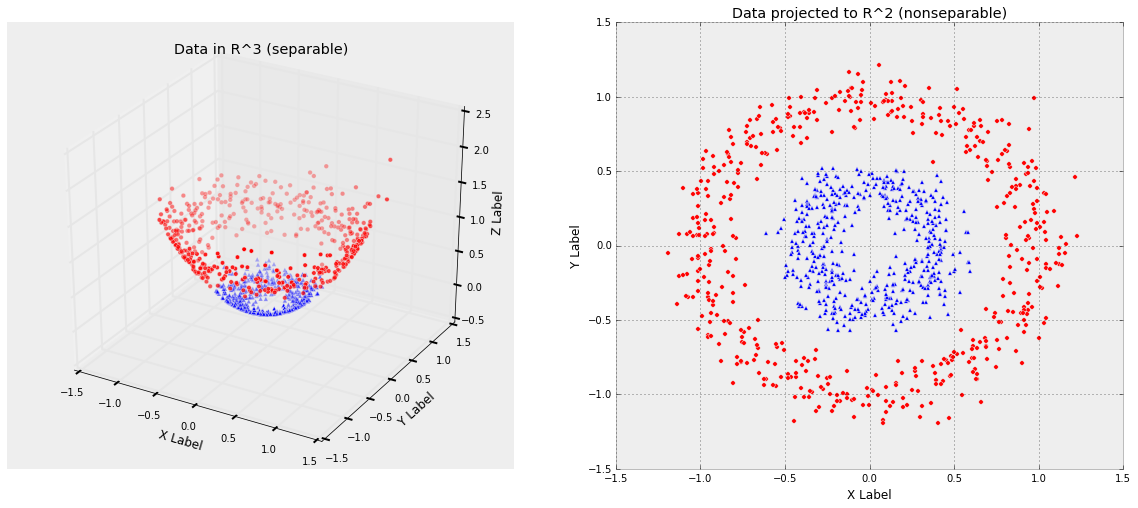

In [10]:
# Polynomial Kernel Example
plot_no_decision_boundary()

### SVM:  Decision Boundary

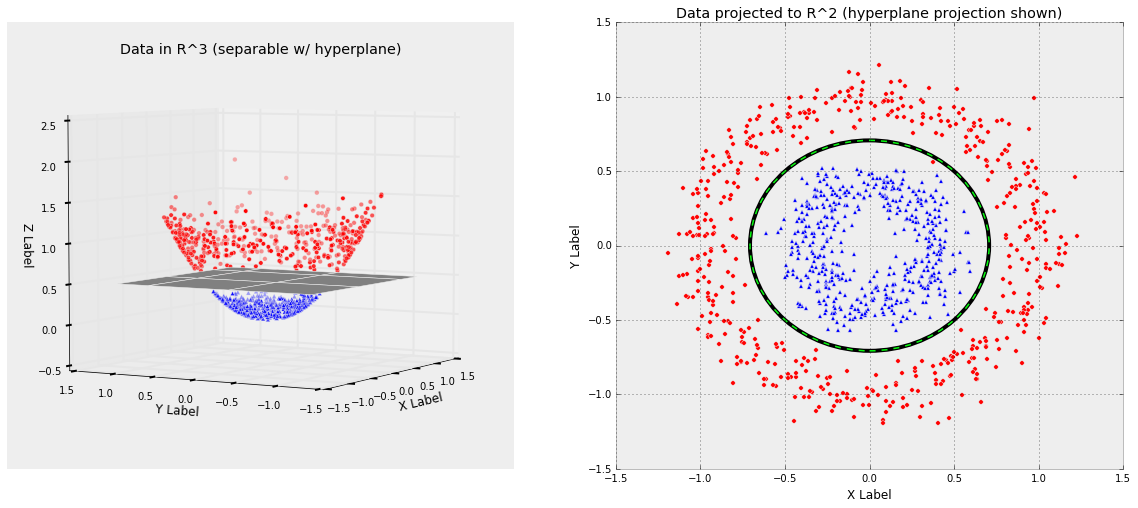

In [11]:
plot_decision_boundary()

### SVM:  Kernels

Choice of kernels
- Gaussian or polynomial kernels are used quite often
- If simple kernels are ineffective, more elaborate kernels can be used (Radial Basis Functions provide an infinite dimensional mapping!)

### SVM:  Kernels

Choice of Kernel Parameters
- Ex: Gaussian Kernel; $K(x, z) = \exp \left(- \frac{{||x - z||}^2}{2\sigma^2} \right)$. As a heuristic, the Bandwidth ($\sigma$) can be chosen to be the distance between neighboring points whose labels will likely affect the prediction of the query point.

### How to solve for the SVM dual?

- "Chunking Algorithm" 

    - Start with a random subset of the data and keep iteratively adding examples which violate the optimality conditions. 
    - Problem: QP problem scales with the number of SVs.
    - Most SVM problems were solved with such algorithms in expensive QP solver softwares prior to SMO (see below).

### Sequential Minimal Optimization 
   - Divide the Dual problem into smaller sub-problems each of which consists of 2 of the linear equality constraint Lagrange multipliers ($\alpha$'s). 
   - Find a lagrange multiplier $\alpha_1$ that violates the KKT conditions. 
   - Pick a second multiplier $\alpha_2$ and optimize the pair $(\alpha_1, \alpha_2)$ using **coordinate ascent**.
   - Repeat the previous 2 steps until convergence (the KKT conditions are satisifed within a user-defined tolernace).
   
See Platt (1998) for details.